# En este proyecto intentaremos predecir el género de una película dado el plot en inglés de la misma.

### Carga de datos y limpieza general

Comenzamos importando las librerias

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud
pd.options.display.max_columns = None

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

Descargamos el dataset de Kaggle de este link: https://www.kaggle.com/jrobischon/wikipedia-movie-plots ... Adicionalmente, revisaremos brevemente la información que contiene el DataSet

In [2]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')

In [3]:
display(df.head(2))
display(df.shape)
display(df["Genre"].value_counts().head())
display("Unique genres values: {}".format(len(df["Genre"].value_counts())))

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."


(34886, 8)

unknown    6083
drama      5964
comedy     4379
horror     1167
action     1098
Name: Genre, dtype: int64

'Unique genres values: 2265'

Vemos que hay muchos generos desconocidos y que hay una variedad muy grande de géneros (2265), por ello decido
traerme otro DataFrame de IMDB con los géneros y posteriormente hacer un join. 


In [4]:
# Importamos el nuevo dataframe  
df_genre = pd.read_csv("title.basics.tsv",delimiter="\t")

/usr/local/Cellar/ipython/7.0.1/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Revisamos la información que nos trae el nuevo DataFrame
display(df_genre.head(3))
df_genre.shape

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"


(5463542, 9)

In [6]:
# Hacemos el Merge 
df_joined = df.merge(df_genre[["originalTitle","genres"]],left_on="Title",right_on="originalTitle").iloc[:35000]

Revisamos la información que tenemos

In [7]:
display("Forma del nuevo df: {}".format(df_joined.shape))

display("Cantidad de películas únicas en el df: {}".format(len(df_joined["Title"].unique().tolist())))

jack = len(df_joined[df_joined["Title"]=="Jack and the Beanstalk"])
display("Hay películas repetidas, por ejemplo, 'Jack and the Beanstalk' aparece {} veces".format(jack))

df_joined[df_joined["Title"] == "Jack and the Beanstalk"][["Title","genres"]].head()

'Forma del nuevo df: (35000, 10)'

'Cantidad de películas únicas en el df: 2329'

"Hay películas repetidas, por ejemplo, 'Jack and the Beanstalk' aparece 86 veces"

,Title,genres
4,Jack and the Beanstalk,"Fantasy,Short"
5,Jack and the Beanstalk,Fantasy
6,Jack and the Beanstalk,"Animation,Short"
7,Jack and the Beanstalk,"Comedy,Short"
8,Jack and the Beanstalk,"Animation,Comedy,Family"


In [8]:
# Nos quedamos únicamente con las features que nos interesan.
df_joined_c = df_joined.loc[:,("Title","Plot","genres")]

# Eliminamos las películas que no tienen un género asignado y las filas que están duplicadas.
df_joined_c = df_joined_c[df_joined_c.loc[:,"genres"] !="\\N"]
df_joined_c.drop_duplicates(inplace=True)
display(df_joined_c.shape)
df_joined_c.head(3)

(19717, 3)

,Title,Plot,genres
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr...","Comedy,Short"
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov...","Comedy,Fantasy,Romance"
2,The Martyred Presidents,"The film, just over a minute long, is composed...",Short


Ya que existen películas que aparecen repetidas muchas veces con distintos géneros asignados (como Jack and the Beanstalk), decido quedarme con el género que más veces aparece repetido por película.

In [9]:
new_df = []
import time
def genres(movie):  
    genres = df_joined_c[df_joined_c["Title"]== movie]["genres"].tolist() # List of genres
    title = df_joined_c[df_joined_c["Title"]== movie]["Title"].iloc[0] # title
    plot = df_joined_c[df_joined_c["Title"]== movie]["Plot"].iloc[0] # plot
    list_genres = (",".join(genres)).split(",") # genres in list 
    genres_proc = pd.Series(list_genres).value_counts().index[:1].tolist() # Top 2 most repeated genres
    inf = {"Title":title,"Plot":plot,"Genres":genres_proc} # Final row to add
    new_df.append(inf)

In [10]:
%%time
unique_titles = df_joined_c["Title"].unique().tolist()
for title in unique_titles:
    genres(title)

CPU times: user 26.3 s, sys: 57.5 ms, total: 26.4 s
Wall time: 26.7 s


In [105]:
movies = pd.DataFrame(new_df)
movies.head(3)

,Genres,Plot,Title
0,[Short],"A bartender is working at a saloon, serving dr...",Kansas Saloon Smashers
1,[Romance],"The moon, painted with a smiling face hangs ov...",Love by the Light of the Moon
2,[Short],"The film, just over a minute long, is composed...",The Martyred Presidents


### Análisis sobre los géneros

In [106]:
genres_array = np.array([])
for i in range(0,len(movies)):
    genres_array = np.concatenate((genres_array, movies['Genres'][i]))


In [13]:
# Lets see thow many movies we have for each genre
gen_df = pd.DataFrame({"Genres":genres_array})
gen_df["Count"] = 1 
mbg = gen_df.groupby("Genres").sum().sort_values(by="Count",ascending=False)
mbg.head

<bound method NDFrame.head of              Count
Genres            
Drama          715
Comedy         484
Romance        221
Short          201
Musical        103
Mystery         99
Western         87
Adventure       69
Crime           58
Documentary     39
Music           36
Horror          35
Family          28
War             27
History         23
Animation       23
Sport           14
Thriller        12
Action          12
Biography       10
Film-Noir        8
Fantasy          6
Reality-TV       6
News             3
Sci-Fi           3
Game-Show        2
Adult            1
Talk-Show        1>

Vemos que la mayoría de las películas pertenecen a unos pocos géneros. Así mismo que el género "Music" y "Musical" se puede agrupar

In [14]:
# Transformamos "Music" en "Musical"
gen_df["Genres"] = gen_df["Genres"].apply(lambda x: "Musical" if x == "Music" else x)
mbg2 = gen_df.groupby("Genres").sum().sort_values(by="Count",ascending=False)

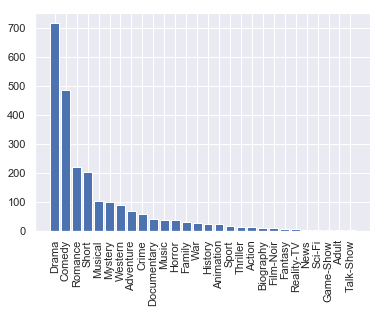

In [15]:
# Creamos un gráfico visual
sns.set()
_ = plt.bar(mbg.index,mbg["Count"],label=mbg.index)
plt.xticks(rotation=90)
plt.show()

In [16]:
# Creamos una tabla de frequencia de distribución para quedarnos con los géneros que incluyen el 95% de los datos.
gen_freq = mbg2.reset_index()
gen_freq["Frequency"] = gen_freq["Count"]/len(gen_df)
gen_freq["Cumulative_Freq"] = gen_freq["Frequency"].cumsum()
gen_freq

,Genres,Count,Frequency,Cumulative_Freq
0,Drama,715,0.307395,0.307395
1,Comedy,484,0.208083,0.515477
2,Romance,221,0.095013,0.610490
3,Short,201,0.086414,0.696905
4,Musical,139,0.059759,0.756664
5,Mystery,99,0.042562,0.799226
6,Western,87,0.037403,0.836629
7,Adventure,69,0.029665,0.866294
8,Crime,58,0.024936,0.891230
9,Documentary,39,0.016767,0.907997


In [59]:
# Filtramos los generos que incluyen el 90% de los datos.
top_genres = np.array(gen_freq[(gen_freq["Cumulative_Freq"]<=0.90) & ( gen_freq["Genres"]!= "Short")]["Genres"])

Ya que conocemos los géneros principales, filtremos nuestro dataframe original. Recordemos que debemos también
sustituir "Music" por "Musical" en nuestos datos originales.

In [40]:
movies["Genres"] = movies["Genres"].apply(lambda x: ["Musical" if word =="Music" else word for word in x])
movies["Genres"] = movies["Genres"].apply(lambda x: np.array(x)[np.in1d(x,top_genres)])
movies = (movies[movies["Genres"].str.len() != 0])

Utilicemos OneHotEncoding para transformar los géneros en columnas con unos y ceros dependiendo de si el género corresponde a esa película o no respectivamente. Esto lo hacemos ya que los algoritmos no entienden de palabras si no de valores numéricos

In [41]:
movies = pd.concat([movies, movies.Genres.apply(lambda x: ','.join(x)).str.get_dummies(sep=',')], axis=1)

In [42]:
movies_cleaned = movies.drop(["Genres"],axis=1)
movies_cleaned.head(3)

,Plot,Title,Comedy,Drama,Musical,Mystery,Romance,Western,Comedy,Drama,Musical,Mystery,Romance,Western,Comedy,Drama,Musical,Mystery,Romance,Western
1,"The moon, painted with a smiling face hangs ov...",Love by the Light of the Moon,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
8,The opening scene shows the interior of the ro...,The Little Train Robbery,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
9,Scenes are introduced using lines of the poem....,The Night Before Christmas,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


### Limpieza de los plots

Comenzamos por crear una serie de funciones que nos permitirán limpiar los plots. Lemmatize convierte distintas palabras de igual significado en la misma, luego las regular expressions y RemoveCharDigit se quedan solo con palabras eliminando números y caractéres especiales, así como conviertiendo palabras compuestas en palabras separadas. 

In [43]:
stop_words = stopwords.words("english")
Stop_word_TryAndError = ["ha","wa","one","get","take","go","back","tell","two","make","see","come","hi","tri"]
lemma=WordNetLemmatizer()
token=ToktokTokenizer()
stemmer = PorterStemmer()

In [44]:
def lemitizeWords(text):
    listLemma = []
    words=token.tokenize(text)
    stem = [stemmer.stem(word) for word in words]
    for w in stem:
        x=lemma.lemmatize(w)
        listLemma.append(x)
    return listLemma

def stopWordsRemove(text):
    wordList =[x.lower().strip() for x in token.tokenize(text)]
    removedList=[x for x in wordList if x not in stop_words and x not in Stop_word_TryAndError]
    text=" ".join(removedList)
    return text

def removeCharDigit(text):
    str="1234567890-=~@#$%^&*()_+[!{;”:\’><.,/?”}]"
    for w in text:
        if w in str:
            text=text.replace(w,"")
    return text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

def PreProcessing(text):
    text = lemitizeWords(text)
    text = stopWordsRemove(text)
    text = clean_text(text)
    text = removeCharDigit(text)
    
    return(text)


In [45]:
ejemplo = " ".join(movies_cleaned[["Plot"]].iloc[9].tolist())
print("Por ejemplo, la frase: {}".format(ejemplo))
print("\nSe convierte en:")
print("\n{}".format(PreProcessing(ejemplo)))

Por ejemplo, la frase: "David Copperfield consists of three reels and as three separate films, released in three consecutive weeks, with three different titles: The Early Life of David Copperfield, Little Em'ly and David Copperfield and The Loves of David Copperfield.[4]

Se convierte en:

david copperfield consist three reel three separ film releas three consecut week three differ titl earli life david copperfield littl em ly david copperfield love david copperfield 


In [46]:
# Apliquemos la funcion a todos los plots. 
movies_cleaned["plot_cleaned"] = movies_cleaned["Plot"].map(lambda x : PreProcessing(x))

### Análisis de las palabras de los plots 

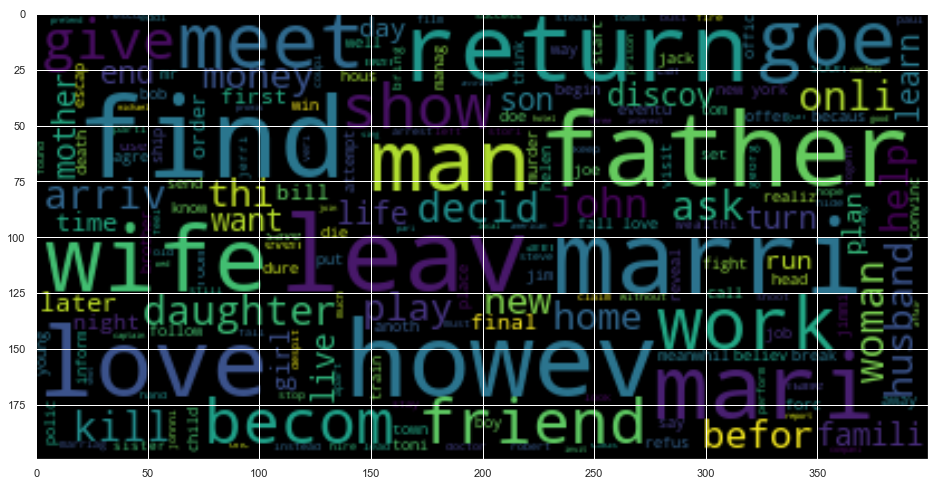

In [47]:
totalText=""
for words in movies_cleaned["plot_cleaned"]:
    totalText += words

wc=WordCloud(background_color="black",max_font_size=50).generate(totalText)
plt.figure(figsize=(16,12))
plt.imshow(wc, interpolation="bilinear")

### Frecuencia con la que aparecen las palabras 

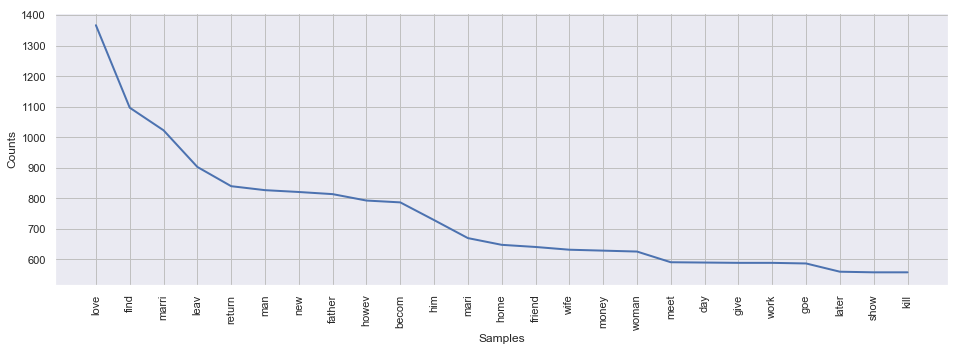

In [48]:
x=nltk.FreqDist(ToktokTokenizer().tokenize(totalText))
plt.figure(figsize=(16,5))
x.plot(25)

Modifiquemos las palabras con one hot encoding, para ello utilizamos CountVectorier y TfidfTransformer

In [49]:
x = movies_cleaned.loc[:,"plot_cleaned"]
cv= CountVectorizer().fit(x)
header = pd.DataFrame(cv.transform(x).todense(),columns=cv.get_feature_names())
tfidfhead=TfidfTransformer().fit(header)
head2 =pd.DataFrame(tfidfhead.transform(header).todense())

### Clasificacion - Entrenamiento y prueba de modelos 

Dividamos la data entre entrenamiento y prueba 

In [103]:
X = head2
y = movies_cleaned.drop(["Plot","plot_cleaned","Title"],axis=1)

X_train,X_test,y_train,y_test=train_test_split(X,y)
X_train.shape , X_test.shape, y_train.shape , y_test.shape

((1308, 18284), (437, 18284), (1308, 18), (437, 18))

Random Forrest with GridSearch and 5 CVF. 

In [104]:
# Random Forest Classifier 
param_grid = { 
           "n_estimators" : [3,4,5,6,7]}
rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf,param_grid,cv=5)
rf_cv.fit(X,y)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'n_estimators': 5}
0.25787965616045844


In [ ]:
rf = RandomForestClassifier(n_estimators = 24)

Probamos con distintos clasificadores con distintas estrategias de multiclasificacion

In [53]:
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())
classifier.fit(xtrain.astype(float), ytrain.astype(float))
predictions = classifier.predict(xtest.astype(float))
accuracy_score(ytest.astype(float),predictions)

0.16247139588100687

In [54]:


# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(GaussianNB())

# train
classifier.fit(xtrain.astype(float), ytrain.astype(float))

# predict
predictions = classifier.predict(xtest.astype(float))
accuracy_score(ytest.astype(float),predictions)

0.16933638443935928

In [55]:
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifierfrom skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(GaussianNB())
classifier.fit(xtrain.astype(float), ytrain.astype(float))
predictions = classifier.predict(xtest.astype(float))
accuracy_score(ytest.astype(float),predictions)

0.36613272311212813

In [56]:
clf=OneVsRestClassifier(MultinomialNB())
clf.fit(x,y)
pred=clf.predict(x)
accuracy_score(y,pred)

0.12206303724928366

## Lets Split our data between train and test and test some classifiers

In [ ]:
# LogReg_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words,ngram_range=(1,3))),
#                 ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
#             ])
TOKENS_ALPHANUMERIC = "[A-Za-z0-9]+(?=\\s+)"

LogReg_pipeline = Pipeline([
                ('vec', CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC,ngram_range=(1,3))),
                ("int", SparseInteractions(degree=2)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

LogReg_pipeline.fit(X_train, y_train)
prediction = LogReg_pipeline.predict_proba(X_test)
pd.DataFrame(prediction)

In [ ]:
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))

In [ ]:
rf = Pipeline([
                ('vec', CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC,ngram_range=(1,3))),
                ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=10), n_jobs=1)),
            ])

rf.fit(X_train, y_train)
prediction = rf.predict_proba(X_test)
pd.DataFrame(prediction)

In [ ]:
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    rf.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = rf.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))

In [ ]:
X = movies_cleaned.loc[:,"Plot_cleaned"]
y = movies_cleaned.iloc[:,3:-1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)
X_train.shape , X_test.shape, y_train.shape , y_test.shape

In [ ]:
1 - len(y_test[y_test["Action"]==1])/len(y_test)

In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

LogReg_pipeline.fit(X_train, y_train)
prediction = LogReg_pipeline.predict_proba(X_test)
pd.DataFrame(prediction)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', RandomForestClassifier()),
            ])

rf.fit(X_train, y_train)
accuracy = rf.score(X_test, y_test)
accuracy

# prediction = rf.predict_proba(X_test)
# pd.DataFrame(prediction)

In [ ]:
contador_LR = 0    
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
    contador_LR += accuracy_score(y_test[genre], prediction)

## SVC

In [ ]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
            ])

SVC_pipeline.fit(X_train, y_train)


La primera vez que hago el SVC e imprimo las matrices de confusion veo que hay colu

In [ ]:
contador_svc = 0    
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
    contador_svc += accuracy_score(y_test[genre], prediction)

# SVC_pipeline.fit(X_train, y_train["Drama"])
# prediction = SVC_pipeline.predict(X_test)
# display(accuracy_score(y_test["Drama"], prediction))
# display(confusion_matrix(y_test["Drama"], prediction))
# print(classification_report(y_test["Drama"], prediction))
                 

## LogisticRegression 

In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])


In [ ]:
contador_LR = 0    
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
    contador_LR += accuracy_score(y_test[genre], prediction)

In [ ]:
MultinomialNB = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])


In [ ]:
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    MultinomialNB.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = MultinomialNB.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
